![](Zillow.jpg)

# Zillow Clustering Project
# Predicting Logerror of Zestimate
## Natasha Rivers
### June 28, 2021

<hr style="border:2px solid black"> </hr>

## Goals: 
- To find what is driving the errors in the Zillow Zestimate
- 'logerror'= predicted sale value - actual sale value

## Executive Summary:
- 

<hr style="border:2px solid black"> </hr>

### Imports

In [1]:
import acquire
import prepare
import explore

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import math

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, explained_variance_score


import warnings
warnings.filterwarnings("ignore")

<hr style="border:2px solid black"> </hr>

## Acquire

In [2]:
#function from acquire.py 
zillow = acquire.get_zillow_file()

In [3]:
zillow.head()

,parcelid,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,transactiondate
0,14297519,0.025595,3.5,4.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,96978.0,1998.0,485713.0,1023282.0,537569.0,11013.72,2017-01-01
1,17052889,0.055619,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,97099.0,1967.0,88000.0,464000.0,376000.0,5672.48,2017-01-01
2,14186244,0.005383,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,97078.0,1962.0,85289.0,564778.0,479489.0,6488.30,2017-01-01
3,12177905,-0.103410,3.0,4.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,96330.0,1970.0,108918.0,145143.0,36225.0,1777.51,2017-01-01
4,12095076,-0.001011,3.0,4.0,2962.0,6037.0,34145202.0,-118179824.0,63000.0,96293.0,1950.0,276684.0,773303.0,496619.0,9516.26,2017-01-01


In [4]:
zillow.dtypes

parcelid                          int64
logerror                        float64
bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
fips                            float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
regionidzip                     float64
yearbuilt                       float64
structuretaxvaluedollarcnt      float64
taxvaluedollarcnt               float64
landtaxvaluedollarcnt           float64
taxamount                       float64
transactiondate                  object
dtype: object

In [5]:
#52916 entries,16 columns, several nulls, incorrect dtypes
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52916 entries, 0 to 52915
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52916 non-null  int64  
 1   logerror                      52916 non-null  float64
 2   bathroomcnt                   52916 non-null  float64
 3   bedroomcnt                    52916 non-null  float64
 4   calculatedfinishedsquarefeet  52814 non-null  float64
 5   fips                          52916 non-null  float64
 6   latitude                      52916 non-null  float64
 7   longitude                     52916 non-null  float64
 8   lotsizesquarefeet             52513 non-null  float64
 9   regionidzip                   52889 non-null  float64
 10  yearbuilt                     52781 non-null  float64
 11  structuretaxvaluedollarcnt    52820 non-null  float64
 12  taxvaluedollarcnt             52915 non-null  float64
 13  l

In [6]:
zillow.shape

(52916, 16)

## Takeaways from Acquire:

- This is a fairly large dataset (2.89M entries)
    - creating a function to save 'get_zillow' into a csv will drastically reduce time to import

<br>

- The data chosen is based somewhat on personal interpretation, different "propertylandusetypeid" may be used 
    - data dictionary with id types I used is available in my README
    
<br>

- The data I chose to work with has:
    - 52,916 entries
    - 16 different columns
    - appear to have some nulls (further explore this in prepare)

<hr style="border:2px solid black"> </hr>

## Prepare

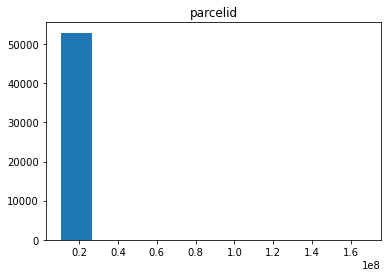

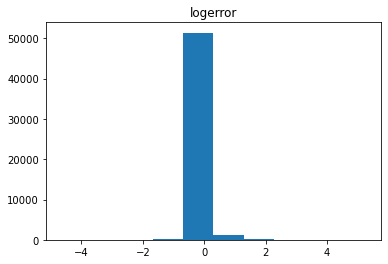

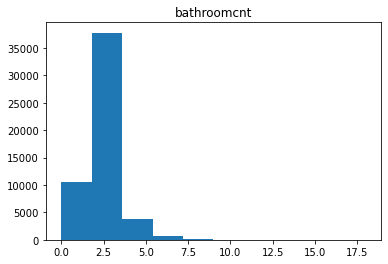

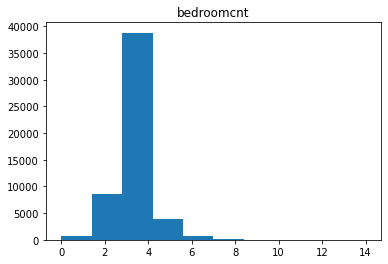

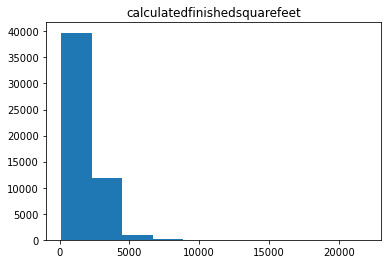

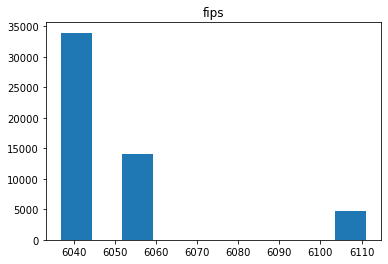

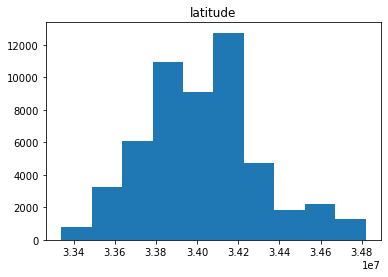

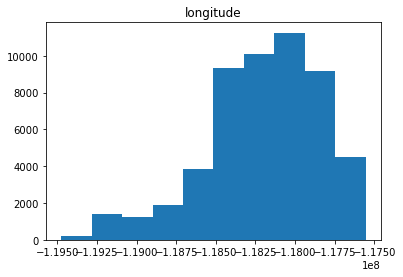

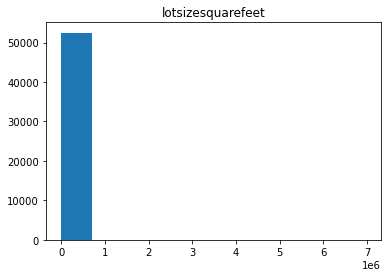

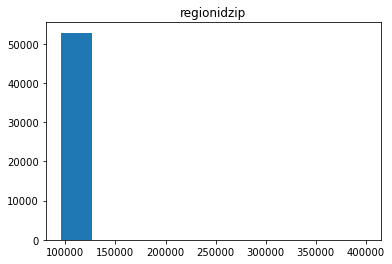

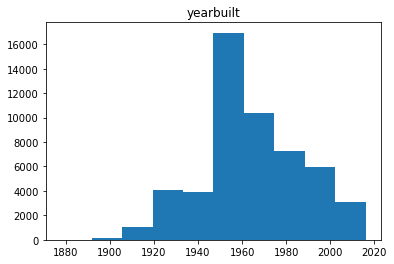

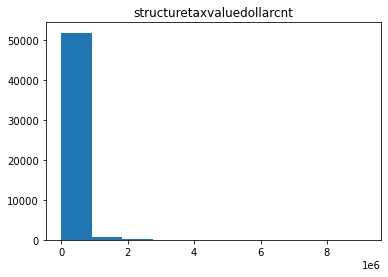

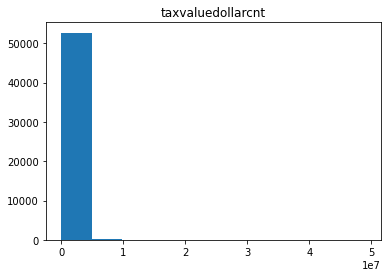

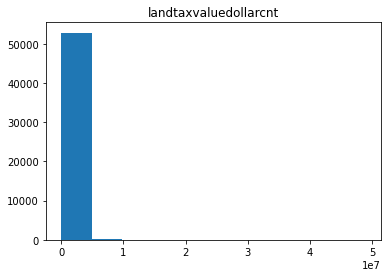

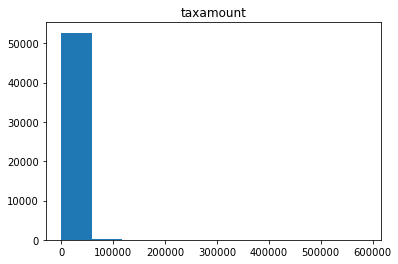

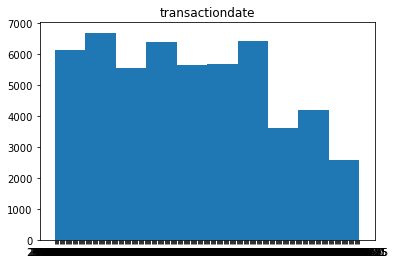

In [7]:
#visualize distributions 
#check for outliers
#visualize distribution
for col in zillow.columns:
    plt.hist(zillow[col])
    plt.title(col)
    plt.show()

______________

### Take a look at outliers:

In [8]:
#function that identifies outliers from prepare.py
prepare.outlier_bound_calculation(zillow, 'bedroomcnt')

For bedroomcnt the lower bound is 1.5 and  upper bound is 5.5


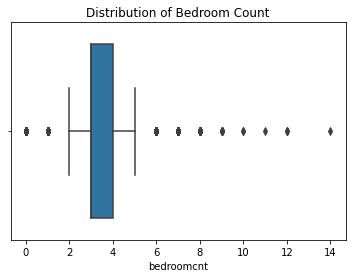

In [9]:
#specifically visualize outliers in bedroom
#thoughts: I need to impute or drop these outliers
sns.boxplot(zillow.bedroomcnt)
plt.title('Distribution of Bedroom Count')
plt.show()

In [10]:
#function that identifies outliers from prepare.py
prepare.outlier_bound_calculation(zillow, 'bathroomcnt')

For bathroomcnt the lower bound is 0.5 and  upper bound is 4.5


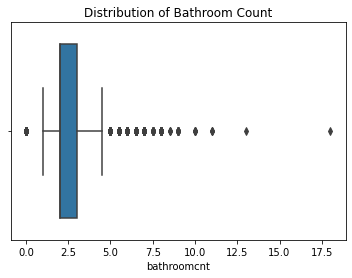

In [11]:
#visualize the same data as above
sns.boxplot(zillow.bathroomcnt)
plt.title('Distribution of Bathroom Count')
plt.show()

## Takeaways from Outliers:
- I will use 'remove_outliers' function from prepare.py to remove outliers that were outside upper_bound (.75) and lower_bound (.25) of IQR

____________

### Take a look at Nulls:

In [12]:
#look at null values
zillow.isnull().sum()

parcelid                          0
logerror                          0
bathroomcnt                       0
bedroomcnt                        0
calculatedfinishedsquarefeet    102
fips                              0
latitude                          0
longitude                         0
lotsizesquarefeet               403
regionidzip                      27
yearbuilt                       135
structuretaxvaluedollarcnt       96
taxvaluedollarcnt                 1
landtaxvaluedollarcnt             2
taxamount                         4
transactiondate                   0
dtype: int64

In [13]:
#take a look at how many nulls there are by row
explore.nulls_by_col(zillow)

,num_rows_missing,pct_rows_missing
parcelid,0,0.000000
logerror,0,0.000000
bathroomcnt,0,0.000000
bedroomcnt,0,0.000000
calculatedfinishedsquarefeet,102,0.192758
fips,0,0.000000
latitude,0,0.000000
longitude,0,0.000000
lotsizesquarefeet,403,0.761584
regionidzip,27,0.051024


In [14]:
#take a look at how many nulls there are by row
explore.nulls_by_row(zillow)

,num_cols_missing,pct_cols_missing,num_rows
0,0,0.0,52305
1,1,6.25,484
2,2,12.5,100
3,3,18.75,24
4,4,25.0,1
5,5,31.25,2


### Takeaways from nulls:

- I will drop null values that fall outside the threshold using 'handling_missing_values' function (.5,.5) from prepare.py
- I will impute the rest of the missing values that were note dropped

________

In [15]:
#function from prepare.py that changes column names, changes dtypes, 
#imputes values, drop nulls and outliers, creates new column with county name

zillow = prepare.final_prep_zillow(zillow)

In [16]:
#as you can see.. column names have been changed
zillow.head()

,parcelid,logerror,bathrooms,bedrooms,total_sqft,county_code,latitude,longitude,lotsizesquarefeet,regionidzip,year_built,structuretaxvaluedollarcnt,value_assessed,landtaxvaluedollarcnt,tax_amount,transactiondate,county,property_age
0,14297519,0.025595,3.5,4,3100,6059,33634931,-117869207,4506,96978,1998,485713,1023282,537569,11013,20170101,orange,19
1,17052889,0.055619,1.0,2,1465,6111,34449266,-119281531,12647,97099,1967,88000,464000,376000,5672,20170101,ventura,50
2,14186244,0.005383,2.0,3,1243,6059,33886168,-117823170,8432,97078,1962,85289,564778,479489,6488,20170101,orange,55
3,12177905,-0.103410,3.0,4,2376,6037,34245180,-118240722,13038,96330,1970,108918,145143,36225,1777,20170101,los_angeles,47
4,12095076,-0.001011,3.0,4,2962,6037,34145202,-118179824,63000,96293,1950,276684,773303,496619,9516,20170101,los_angeles,67


In [17]:
#prepare.py also changed dtypes
zillow.dtypes

parcelid                        int64
logerror                      float64
bathrooms                     float64
bedrooms                        int64
total_sqft                      int64
county_code                     int64
latitude                        int64
longitude                       int64
lotsizesquarefeet               int64
regionidzip                     int64
year_built                      int64
structuretaxvaluedollarcnt      int64
value_assessed                  int64
landtaxvaluedollarcnt           int64
tax_amount                      int64
transactiondate                 int64
county                         object
property_age                    int64
dtype: object

In [18]:
#prepare.py dropped nulls outside of threshold 
#and imputed the rest of the null values 
zillow.isnull().sum()

parcelid                      0
logerror                      0
bathrooms                     0
bedrooms                      0
total_sqft                    0
county_code                   0
latitude                      0
longitude                     0
lotsizesquarefeet             0
regionidzip                   0
year_built                    0
structuretaxvaluedollarcnt    0
value_assessed                0
landtaxvaluedollarcnt         0
tax_amount                    0
transactiondate               0
county                        0
property_age                  0
dtype: int64

In [19]:
#new shape after dropping outliers and nulls that were not imputed
zillow.shape

(48646, 18)

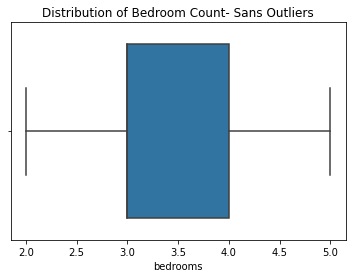

In [20]:
#NOW visualize bedroom count after outliers were dropped 
sns.boxplot(zillow.bedrooms)
plt.title('Distribution of Bedroom Count- Sans Outliers')
plt.show()

In [21]:
#take a look at our target
zillow.logerror.describe()

count    48646.000000
mean         0.016453
std          0.168115
min         -4.655420
25%         -0.025060
50%          0.006019
75%          0.038153
max          3.394544
Name: logerror, dtype: float64

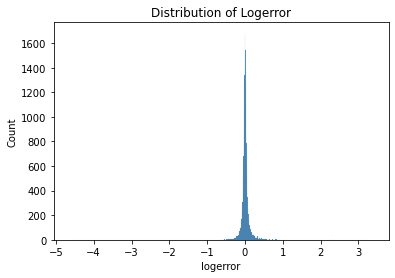

In [22]:
#taxvalue with outliers removed
sns.histplot(data=zillow.logerror)
plt.title('Distribution of Logerror')
plt.show()

In [23]:
#train validate test split
#split data using zillow_split function from prepare.py
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.zillow_split(zillow, 'logerror')

train -> (27241, 18)
validate -> (11675, 18)
test -> (9730, 18)


## Takeaways from Prepare 
- several columns were renamed in order to make them more legible
- duplicates were dropped on parcelid
- null values:
    - dropped if they fell outside of the threshold (0.5 column, 0.5 rows)
    - if fell inside the threshold, null values were imputed by 'mean' and 'most frequent'
- outliers were dropped from bedrooms, bathrooms, total_sqft columns
- created column titled "county" that uses county_code to name column
- final dataframe contains 48236 entries with 19 columns 

<hr style="border:2px solid black"> </hr>

## Explore

In [24]:
#function from explore.py
#summary = explore.summarize(zillow)

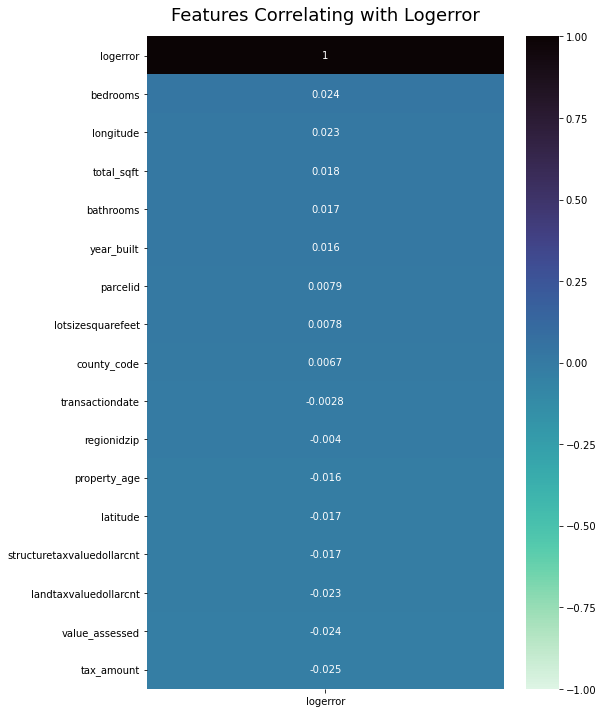

In [25]:
#see what correlates most with logerror
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(zillow.corr()[['logerror']].sort_values(by='logerror', ascending=False), vmin=-1, vmax=1, annot=True, cmap='mako_r')
heatmap.set_title('Features Correlating with Logerror', fontdict={'fontsize':18}, pad=16);

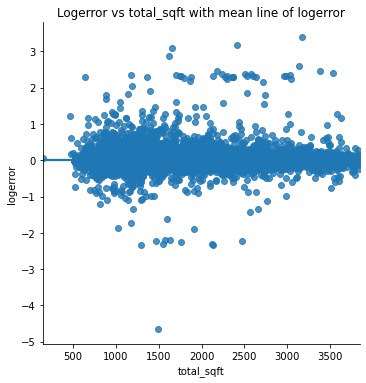

In [26]:
#visualize Log error vs total_sqft
sns.lmplot(x='total_sqft', y='logerror', data=train)
plt.title('Logerror vs total_sqft with mean line of logerror')
plt.show()

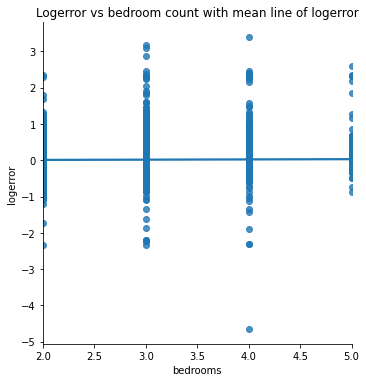

In [27]:
#visualize log error vs bedroom count
sns.lmplot(x='bedrooms', y='logerror', data=train)
plt.title('Logerror vs bedroom count with mean line of logerror')
plt.show()

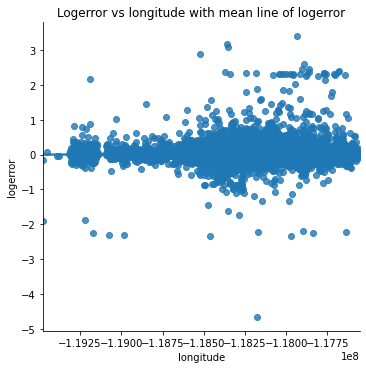

In [28]:
#visualize log error vs longitude
sns.lmplot(x='longitude', y='logerror', data=train)
plt.title('Logerror vs longitude with mean line of logerror')
plt.show()

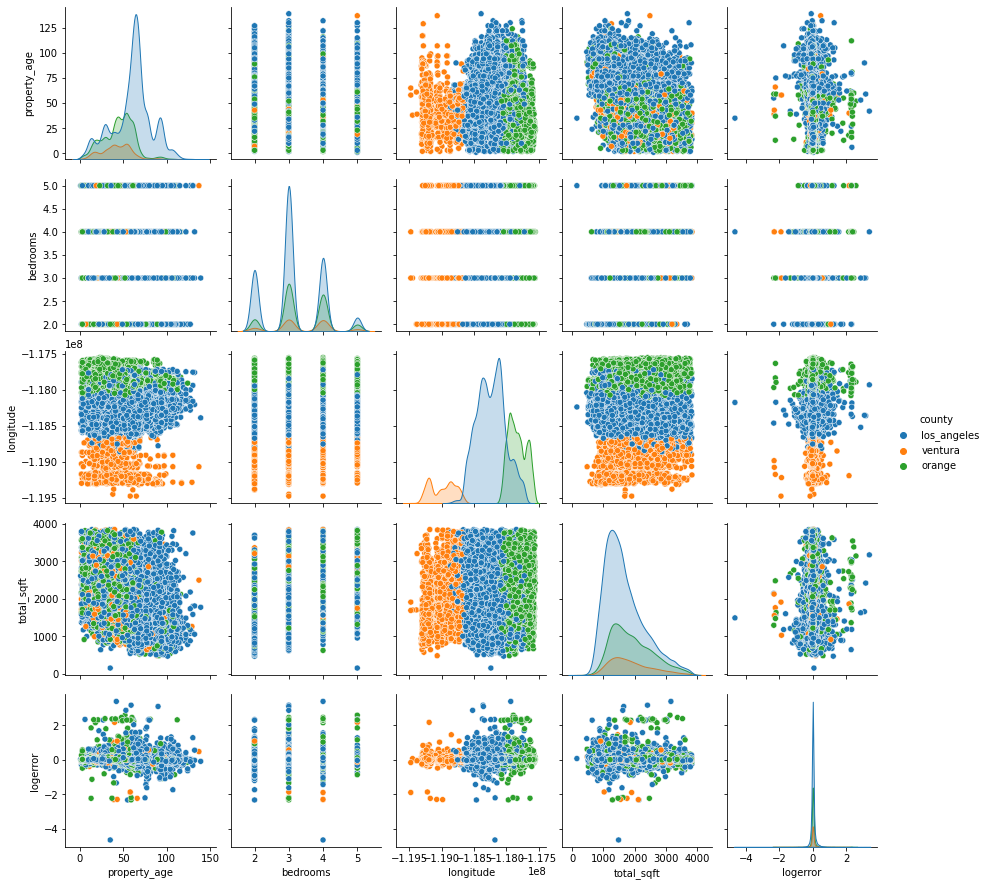

In [29]:
#create pairplot by county in train dataset
cols = ['property_age', 'bedrooms', 'longitude', 'total_sqft', 'logerror', 'county']

sns.pairplot(data = train[cols], hue = 'county')
plt.show()

### Takeaways:
- Logerror and total_sqft seem to have some clustering by county

In [30]:
numeric_cols = ['property_age', 'bathrooms', 'bedrooms', 'total_sqft',
       'county_code', 'latitude', 'longitude', 'lotsizesquarefeet', 'regionidzip', 'year_built',
       'structuretaxvaluedollarcnt', 'value_assessed', 'landtaxvaluedollarcnt',
       'tax_amount']

In [31]:
#use minmaxscaler function from prepare.py
X_train_scaled, X_validate_scaled, X_test_scaled = prepare.min_max_scaler(X_train, X_validate, X_test, numeric_cols)

In [32]:
X_train_scaled

,parcelid,bathrooms,bedrooms,total_sqft,county_code,latitude,longitude,lotsizesquarefeet,regionidzip,year_built,structuretaxvaluedollarcnt,value_assessed,landtaxvaluedollarcnt,tax_amount,transactiondate,county,property_age
4117,11296376,0.333333,0.333333,0.333875,0.0,0.922037,0.715488,0.000764,0.004399,0.804348,0.022038,0.008389,0.001891,0.014778,20170127,los_angeles,0.195652
28813,12476553,0.333333,0.333333,0.288076,0.0,0.358030,0.701522,0.000874,0.000744,0.536232,0.030799,0.016949,0.008044,0.018451,20170601,los_angeles,0.463768
29847,11125066,0.666667,0.666667,0.639295,0.0,0.748972,0.522774,0.001250,0.001287,0.978261,0.106321,0.050480,0.019555,0.054952,20170606,los_angeles,0.021739
47242,17073351,0.166667,0.333333,0.240650,1.0,0.655605,0.096677,0.001135,0.003619,0.615942,0.011844,0.004678,0.001178,0.004215,20170823,ventura,0.384058
29768,12249440,1.000000,1.000000,0.641734,0.0,0.367867,0.613589,0.000901,0.000402,0.347826,0.061174,0.035611,0.018012,0.036941,20170606,los_angeles,0.652174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52021,11305595,0.333333,0.333333,0.460976,0.0,0.908939,0.669566,0.000821,0.004402,0.818841,0.035080,0.012932,0.002592,0.018552,20170913,los_angeles,0.181159
51957,10714822,0.333333,0.666667,0.436043,0.0,0.591375,0.448747,0.000987,0.001176,0.579710,0.041829,0.035741,0.024058,0.036732,20170913,los_angeles,0.420290
26148,12619470,0.333333,0.666667,0.382656,0.0,0.310910,0.628447,0.000553,0.000813,0.644928,0.014880,0.006056,0.001671,0.010471,20170522,los_angeles,0.355072
34018,12807330,0.000000,0.333333,0.215718,0.0,0.422872,0.731620,0.000704,0.000632,0.521739,0.017281,0.024496,0.019960,0.043360,20170623,los_angeles,0.478261


_______________________

## Hypothesis Testing:

- correlation testing: tests 2 continuous variables
- pearsons looks to find if two sample have a **linear** relationship
- r, p = stats.pearsonsr(x,y)

<br>

- T-Test: tests a continuous and a discrete variable
- t, p = stats.ttest_ind(x,y, equal_var= )


### Hypothesis 1: Correlation Test (Sqft vs Logerror)
- $H_0$: There is no correlation between logerror and total square feet of the property
- $H_a$: There is a correlation between logerror and total square feet of the property

In [33]:
#set alpha
alpha = .05

r, p = stats.pearsonr(train.total_sqft, train.logerror)
print('r-value:',round(r,4),'p-value:',round(p,4))

r-value: 0.0226 p-value: 0.0002


In [34]:
if p <alpha: 
    print('We fail to reject null hypothesis')
else:
    print('We reject our null hypothesis')

We fail to reject null hypothesis


___________

### Hypothesis 2: Correlation Test (Sqft vs Property_Age)
- $H_0$: There is no correlation between logerror and age of the property
- $H_a$: There is a correlation between logerror and age of the property

In [35]:
#set alpha
alpha = .05

r, p = stats.pearsonr(train.property_age, train.logerror)
print('r-value:',round(r,4),'p-value:',round(p,4))

r-value: -0.0145 p-value: 0.0167


In [36]:
if p <alpha: 
    print('We fail to reject null hypothesis')
else:
    print('We reject our null hypothesis')

We fail to reject null hypothesis


____________________

### Hypothesis 3: Correlation Test (Longitude vs Logerror)
- $H_0$: There is no correlation between logerror and longitude
- $H_a$: There is a correlation between logerror and longitude

In [37]:
#set alpha
alpha = .05
#r,p = stats.pearsonsr(x,y)
r, p = stats.pearsonr(train.longitude, train.logerror)

print('r-value:',round(r,4),'p-value:',round(p,4))

r-value: 0.0273 p-value: 0.0


In [38]:
if p <alpha: 
    print('We fail to reject null hypothesis')
else:
    print('We reject our null hypothesis')

We fail to reject null hypothesis


_____________________

### Hypothesis 4: T-Test (Bedrooms vs Logerror)
- $H_0$: There is no relationship between logerror and bedroom count
- $H_a$: There is a relationship between logerror and bedroom count

In [39]:
#set alpha
alpha = .05

In [40]:
# sample size, must be more then 30 to meet assumption
train.logerror.count(), train.bathrooms.count()

(27241, 27241)

In [41]:
#check variance
train.value_assessed.var(), train.bathrooms.var()

#this shows not equal varient

(177779642409.21225, 0.5688047948694398)

In [42]:
#t-test on entire train set
t, p = stats.ttest_ind(train.bathrooms,train.logerror, equal_var=False)

print('t-value:',round(t,4),'p-value:',round(p,4))

t-value: 455.6322 p-value: 0.0


In [43]:
if p <alpha: 
    print('we fail to reject null hypothesis')
else:
    print('We reject our null hypothesis')

we fail to reject null hypothesis


<hr style="border:2px solid black"> </hr>

### Clustering

In [44]:
X = train[['property_age', 'bedrooms', 'total_sqft']]

In [45]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
kmeans.predict(X)

array([1, 1, 2, ..., 5, 4, 5], dtype=int32)

In [46]:
X['cluster'] = kmeans.predict(X)
X.head()

,property_age,bedrooms,total_sqft,cluster
4117,28,3,1384,1
28813,65,3,1215,1
29847,4,4,2511,2
47242,54,3,1040,4
29768,91,5,2520,2


In [47]:
#centroids for unscaled data
centroids = X.groupby('cluster')['property_age', 'total_sqft'].mean()
centroids

,property_age,total_sqft
cluster,,
0,47.686023,2122.069998
1,59.989710,1337.691725
2,39.876023,2634.780680
3,35.406452,3300.925513
4,69.893587,984.885495
5,53.479498,1696.186946


In [48]:
#pass on a string for contrasting colors
X['cluster'] = 'cluster_' + X.cluster.astype(str)
X.head()

,property_age,bedrooms,total_sqft,cluster
4117,28,3,1384,cluster_1
28813,65,3,1215,cluster_1
29847,4,4,2511,cluster_2
47242,54,3,1040,cluster_4
29768,91,5,2520,cluster_2


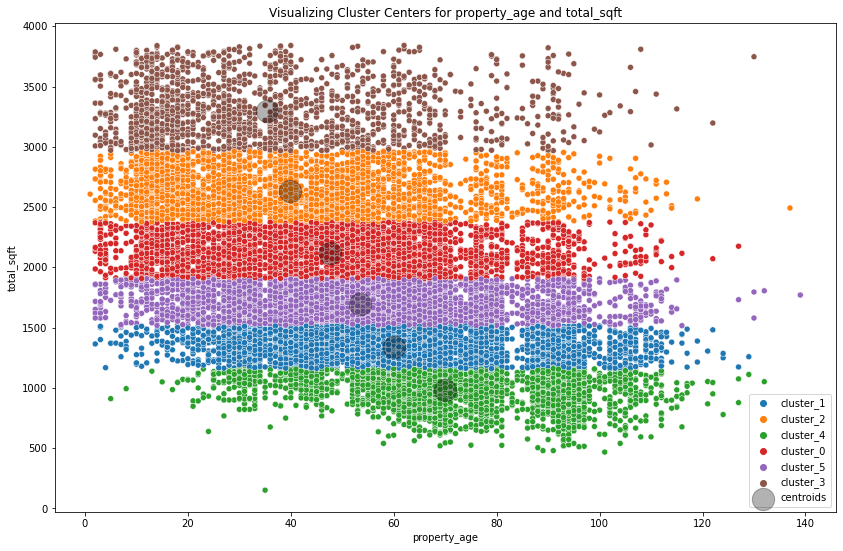

In [49]:
#visualize the clusters along with the centers on unscaled data.
plt.figure(figsize=(14, 9))

# scatterplot of data with hue for cluster
sns.scatterplot(x='property_age', 
                y='total_sqft', 
                data=X, 
                hue='cluster')

# plot cluster centers (centroids)
centroids.plot.scatter(x='property_age', 
                              y='total_sqft', 
                              ax=plt.gca(), 
                              color='k', 
                              alpha=0.3, 
                              s=500, 
                              marker='o', 
                              label='centroids')

plt.title('Visualizing Cluster Centers for property_age and total_sqft')
plt.legend();

In [50]:
kmeans.cluster_centers_

array([[4.76771583e+01, 3.58430755e+00, 2.12056295e+03],
       [5.99885567e+01, 2.97825776e+00, 1.33667530e+03],
       [3.99069767e+01, 3.86172219e+00, 2.63297109e+03],
       [3.54255692e+01, 4.05137186e+00, 3.29936019e+03],
       [6.99167682e+01, 2.48599269e+00, 9.84280958e+02],
       [5.35377027e+01, 3.26801538e+00, 1.69489316e+03]])

## Cluster Takeaways:

- **cluster_0**: properties of ~1900 to ~2400 sqft 
- **cluster_1**: properties of ~1000 to ~1500 sqft
- **cluster_2**: properties of ~2400 to ~3000 sqft 
- **cluster_3**: properties of ~3000 to ~4000 sqft 
- **cluster_4**: properties of ~600 to ~1000 sqft 
- **cluster_5**: properties of ~1500 to ~1900 sqft 


<hr style="border:2px solid black"> </hr>

# Model

In [51]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame({'actual': y_train})
y_validate = pd.DataFrame({'actual': y_validate})
y_test = pd.DataFrame({'actual': y_test})

## Create Baseline

In [52]:
#create the baseline
baseline= y_train['actual'].mean()

In [53]:
#create column called baseline to compare
y_train['baseline'] = baseline

In [54]:
#calculate RMSE for baseline model
rmse_baseline_train= math.sqrt(mean_squared_error(y_train.actual, y_train.baseline))

In [55]:
# predict validate
y_validate['baseline'] = baseline

# evaluate: rmse
rmse_baseline_validate = math.sqrt(mean_squared_error(y_validate.actual, y_validate.baseline))

In [56]:
#create a dataframe to make data easier to visualize/understand
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_train': round(rmse_baseline_train, 4),
    'rmse_validate': round(rmse_baseline_validate, 4)
}])

metric_df
#we now have out baseline model to work off of

,model,rmse_train,rmse_validate
0,mean_baseline,0.1653,0.171


In [57]:
#set features
#we do not want to include all columns in this because it could cause overfitting
features = ['total_sqft', 'bedrooms', 'longitude']

__________________

## Model #1: OLS 

In [58]:
#ordinary least squares
#create the model 
model1 = LinearRegression(normalize=True)

#fit the model
model1.fit(X_train_scaled[features], y_train.actual)

LinearRegression(normalize=True)

In [59]:
# predict train
y_train['logerror_pred_lm'] = model1.predict(X_train_scaled[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.actual, y_train.logerror_pred_lm)**(1/2)

# predict validate
y_validate['logerror_pred_lm'] = model1.predict(X_validate_scaled[features])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.actual, y_validate.logerror_pred_lm)**(1/2)

In [60]:
#create visual to see baseline vs LinearRegression model
metric_df = metric_df.append(
    {
    'model': 'Model 1: OLS',
    'rmse_train': round(rmse_train, 4),
    'rmse_validate': round(rmse_validate,4),
    }, ignore_index=True)

metric_df

,model,rmse_train,rmse_validate
0,mean_baseline,0.1653,0.171
1,Model 1: OLS,0.1651,0.171


__________________________

## Model #2: Lasso Lars

In [61]:
# create the model object
model2 = LassoLars(alpha= 2)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
model2.fit(X_train_scaled[features], y_train.actual)

# predict train
y_train['logerror_pred_lars'] = model2.predict(X_train_scaled[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.actual, y_train.logerror_pred_lars)**(1/2)

# predict validate
y_validate['logerror_pred_lars'] = model2.predict(X_validate_scaled[features])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.actual, y_validate.logerror_pred_lars)**(1/2)

In [62]:
#shows baseline vs LinearRegression vs LassoLars
metric_df = metric_df.append(
    {
    'model': 'Model 2: LassoLars (alpha 2)',
    'rmse_train': round(rmse_train,4),
    'rmse_validate': round(rmse_validate,4),
    }, ignore_index=True)

metric_df

,model,rmse_train,rmse_validate
0,mean_baseline,0.1653,0.171
1,Model 1: OLS,0.1651,0.171
2,Model 2: LassoLars (alpha 2),0.1653,0.171


____________________

## Model #3: Polynomial Features

In [63]:
#make the polynomial features to get a new set of features
model3 = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled features
X_train_degree2 = model3.fit_transform(X_train_scaled[features])

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = model3.transform(X_validate_scaled[features])
X_test_degree2 = model3.transform(X_test_scaled[features])

In [64]:
#create the model
model3 = LinearRegression(normalize=True)

#fit the mode
model3.fit(X_train_degree2, y_train.actual)

#use the model
y_train['logerror_pred_pm'] = model3.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.actual, y_train.tv_pred_pm) ** (1/2)

# predict validate
y_validate['logerror_pred_pm'] = model3.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.actual, y_validate.tv_pred_pm) ** (1/2)

AttributeError: 'DataFrame' object has no attribute 'tv_pred_pm'

In [ ]:
#shows baseline vs LinearRegression vs LassoLars
metric_df = metric_df.append(
    {
    'model': 'Model 3: Polynomial Regression (degree=2)',
    'rmse_train': round(rmse_train,4),
    'rmse_validate': round(rmse_validate,4),
    }, ignore_index=True)

metric_df

<hr style="border:2px solid black"> </hr>

## Utlimate Takeaways:

- negotitation **cannot** be a data point
<br>

- As much as the Zestimate may be accurate... the buyers may negotiate based on **their** perceived value of the property thus dropping the sale value, causing the zestimate to be off and increasing logerror
